In [83]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [84]:
inputs_train = pd.read_csv("../../data/cleaned/unemp_inputs_train_det.csv")
inputs_train = inputs_train.drop(columns=["id"], axis=1)

labels_train = pd.read_csv("../../data/cleaned/unemp_labels_train_det.csv")
labels_train = labels_train.drop(columns=["id"], axis=1)

inputs_test = pd.read_csv("../../data/cleaned/unemp_inputs_test_det.csv")
inputs_test = inputs_test.drop(columns=["id"], axis=1)

labels_test = pd.read_csv("../../data/cleaned/unemp_labels_test_det.csv")
labels_test = labels_test.drop(columns=["id"], axis=1)

In [85]:
# For LSTM, the imput shape is in the form of (samples, timesteps, features)
# reshape input to be 3D [samples, timesteps, features]

inputs_train_shape = (inputs_train.shape[0], -1, inputs_train.shape[1])
inputs_test_shape = (inputs_test.shape[0], -1, inputs_test.shape[1])

inputs_train = inputs_train.values.reshape(inputs_train_shape)
inputs_test = inputs_test.values.reshape(inputs_test_shape)
print('inputs_train:', inputs_train.shape, 'labels_train:', labels_train.shape, 
      '\ninputs_test:', inputs_test.shape, 'labels_test:', labels_test.shape)

inputs_train: (615, 1, 121) labels_train: (615, 1) 
inputs_test: (145, 1, 121) labels_test: (145, 1)


In [92]:
def fit_network(n_neurons=50, batch_size=10, epochs=5, optimizer='adam', verbosity=2):
    
    # design network
    model = Sequential()
    model.add(LSTM(n_neurons, input_shape=(inputs_train.shape[1], inputs_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer=optimizer, metrics=['mse'])

    # Run network
    history = model.fit(inputs_train, labels_train, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=verbosity)
    
    return (model, history)

model_lstm, history = fit_network(verbosity=2)


Epoch 1/5
62/62 - 2s - loss: 0.5603 - mse: 0.3786 - 2s/epoch - 34ms/step
Epoch 2/5
62/62 - 0s - loss: 0.1369 - mse: 0.0287 - 91ms/epoch - 1ms/step
Epoch 3/5
62/62 - 0s - loss: 0.1177 - mse: 0.0227 - 83ms/epoch - 1ms/step
Epoch 4/5
62/62 - 0s - loss: 0.1174 - mse: 0.0227 - 87ms/epoch - 1ms/step
Epoch 5/5
62/62 - 0s - loss: 0.1172 - mse: 0.0226 - 91ms/epoch - 1ms/step


Test loss: 0.15943577885627747
Test mean squared error: 0.04158203676342964


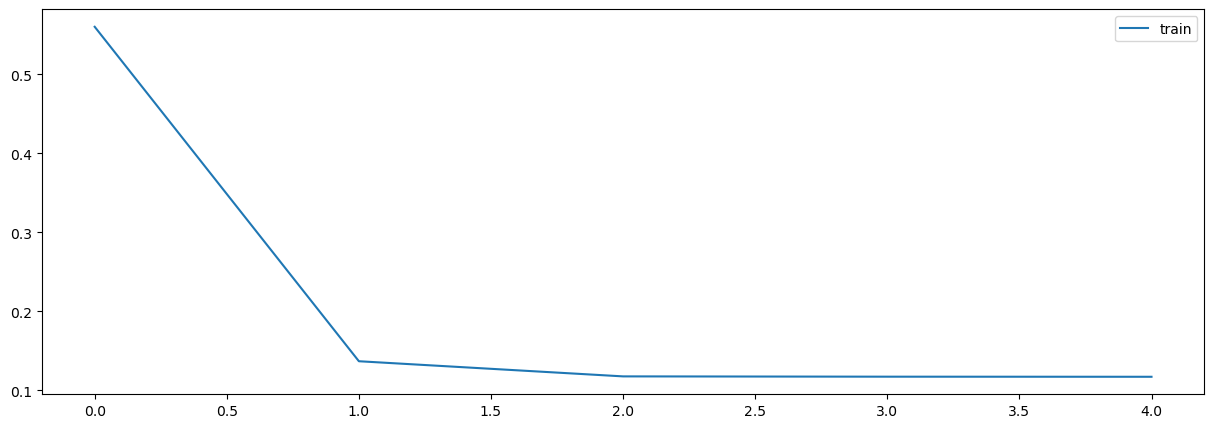

In [93]:
loss, mse = model_lstm.evaluate(inputs_test, labels_test, verbose=0)
print('Test loss:', loss)
print('Test mean squared error:', mse)

# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [88]:
y_pred_out = model_lstm.predict(inputs_train)

#=======================================================  inverting scaling
def inverting(series, ls=-1):
    return scaler.inverse_transform(np.concatenate((reframed_test.values[:, :ls], series), axis=1))[:, -1]

y_pred_lstm_E = inverting(y_pred_out)
y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

#======================================================= metrics
# calculate RMSE
rmse_lstm = tf.math.sqrt(MSE(y_inv, y_pred_lstm_E))
print('Test RMSE: %.3f' % rmse_lstm)

# calculate model accuracy
accuracy_lstm = r2_score(y_inv, y_pred_lstm_E)
print('Model accuracy: {:.3f}'.format(accuracy_lstm))

# calculate mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) 
                    == np.sign(predicted[1:] - predicted[:-1])).astype(int))
mda_lstm = mda(y_inv, y_pred_lstm_E)

print('Model Mean Directional accuracy: {:.3f}'.format(mda_lstm))

NameError: name 'scaler' is not defined

In [ ]:
hours_df = reframed_test.index
plt.figure(figsize=(15, 5))
plt.plot(hours_df, y_inv, label='Consumption')
plt.plot(hours_df, y_pred_lstm_E, label='Prediction (auto-regressive LSTM)')
plt.plot(hours_df, y_pred_model_1, label='Prediction (linear regressor)', linewidth=0.5)
plt.ylabel('Solar energy consumption')
plt.xlabel('Date')
plt.title('Multi-feature models')
plt.savefig('roll_24_multi.png')
plt.legend()
plt.show()

In [ ]:
def lstm_net(X_train_in, y_train, X_test_in, y_test):
    
    model, history = fit_network(verbosity=0)
    y_pred_out = model.predict(X_test_in)

    # invert scaling for forecast and actual
    y_pred = inverting(y_pred_out)
    y_inv = inverting(y_test.values.reshape(y_test.shape[0], 1))

    # metrics
    rmse = sqrt(MSE(y_inv, y_pred))
    LSTM_accuracy = r2_score(y_inv, y_pred)
    mean_da = mda(y_inv, y_pred)
    
    return (rmse, y_inv, y_pred, LSTM_accuracy, mean_da)

import time
from tqdm import tqdm
    
rmse_l, y_inv_l, y_pred_l, acc_l, mda_l = [], [], [], [], []
for i in tqdm(range(11)):  #31
    tqdm._instances.clear()
    
    rmse, y_inv, y_pred, acc, mdacc = lstm_net(X_train_in, y_train, X_test_in, y_test)
    
    rmse_l.append(rmse)
    y_inv_l.append(y_inv)
    y_pred_l.append(y_pred)
    acc_l.append(acc)
    mda_l.append(mdacc)
    
# getting the index of the median rmse value and extract the predictions of this value
rsme_df = pd.DataFrame(rmse_l)
rsme_med = pd.DataFrame(rmse_l).median().values[0]
ind_med = rsme_df[rsme_df[0]==rsme_med].index.tolist()[0]
y_pred_lstm = y_pred_l[ind_med]

fig, ax = plt.subplots(1, 3, figsize=(15,5))
pd.DataFrame(rmse_l, columns=['RMSE']).boxplot(figsize=(7,6), ax=ax[0])
pd.DataFrame(acc_l, columns=['Accuracy']).boxplot(figsize=(7,6), ax=ax[1])
pd.DataFrame(mda_l, columns=['MDAccuracy']).boxplot(figsize=(7,6), ax=ax[2])
# plt.savefig('RMSE.pdf')
plt.show()